# Water Pixels Clustering for In-Situ Points

## Import Libraries

In [1]:
# Import libraries
import os
import platform
from math import atan2, cos, radians, sin, sqrt

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from matplotlib.ticker import FormatStrFormatter
from rasterio.mask import mask
from rasterio.plot import show as rio_show
from rasterio.windows import from_bounds
from shapely.geometry import MultiPoint, Point
from sklearn.cluster import DBSCAN
from tqdm.auto import tqdm

# Set base directory
if platform.system() == 'Darwin':  # macOS
    base_FP = '/Users/lsj'
    cpuserver_data_FP = base_FP + '/cpuserver_data'
    nas_data_FP = '/Volumes/qnap_nas'
elif platform.system() == 'Linux':  # Linux systems (Workstation / CPU Server GPU Server)
    base_FP = '/home/seongjun'
    cpuserver_data_FP = base_FP + '/cpuserver_data' # Workstation / GPU Server
    if not os.path.exists(cpuserver_data_FP):
        cpuserver_data_FP = '/data' # CPU Server
    nas_data_FP = base_FP + '/NAS'

In [2]:
# Calculate the distance between two points on the Earth's surface in meters
def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate the distance between two points on the Earth's surface in meters."""
    R = EARTH_RADIUS
    lat1_rad, lon1_rad = radians(lat1), radians(lon1)
    lat2_rad, lon2_rad = radians(lat2), radians(lon2)
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = sin(dlat / 2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

## 1. Preprocessing

### 1.1 Load Data

In [3]:
# Define paths
obs_df_path = os.path.join(nas_data_FP, 'water_quality/WEIS_data/WEIS_obs_filtered_2013_2024.csv')
pekel_tif_path= os.path.join(cpuserver_data_FP, 'Pekel/Korea/water_occurrence_Korea.tif')
output_path = os.path.join(nas_data_FP, 'water_quality/DBSCAN/obs_water_clusters.json')

In [4]:
# Load metadata for in-situ observations
obs_df = pd.read_csv(obs_df_path, usecols=['ptNo', 'ptNm', 'latitude', 'longitude'])
obs_df.drop_duplicates(subset=['ptNo'], inplace=True)
obs_df.reset_index(drop=True, inplace=True)
obs_df

,ptNo,ptNm,latitude,longitude
0,1001A05,송천1,37.658611,128.676389
1,1001A10,송천4,37.491389,128.717778
2,1001A15,골지천2,37.320000,128.977778
3,1001A20,번천,37.345278,128.974167
4,1001A25,골지천4,37.473611,128.729444
...,...,...,...,...
2018,5303D30,광대저수지,34.797500,125.985000
2019,5303D40,고서저수지,34.757778,125.905000
2020,5303D50,발매저수지,34.702222,125.922222
2021,5303D60,원산저수지,34.790833,126.110556


## 2. DBSCAN

### 2.1 Set Parameters

In [5]:
# 1. General parameters
# Search radius around the observation point (meters)
SEARCH_RADIUS_M = 500

# Distance threshold to consider a pixel as a cluster (meters)
DISTANCE_THRESHOLD = 300

# Minimum occurrence frequency to be considered as water (0-100)
WATER_THRESHOLD = 10

# Earth radius (meters) - used for Haversine distance calculation
EARTH_RADIUS = 6371000

# 2. DBSCAN parameters
# eps: Maximum distance to consider as a neighbor within a cluster (in meters).
#      Consider the pixel resolution (approximately 30m).
EPS = 45

# min_samples: Minimum number of pixels required to form a cluster
MIN_SAMPLES = 5

## 2.2 DBSCAN Clustering for In-Situ Points

In [6]:
# 1. Create the dictionary to save the results
# example: { 'observation point number': [ [cluster1_coordinates], ... ] }
results = {}

# Create the list to store failed observation points
failed_points = []

# 2. Convert the DBSCAN eps parameter from meters to radians
eps_rad = EPS / EARTH_RADIUS

# 3. Open the GeoTIFF file
with rasterio.open(pekel_tif_path) as src:
    # Iterate over each observation point
    for index, row in tqdm(obs_df.iterrows(), total=len(obs_df), desc="Processing observation points"):
        pt_no = row['ptNo']
        lat = row['latitude']
        lon = row['longitude']

        # Calculate the approximate search radius in degrees
        # The actual distance of 1 degree of longitude varies depending on latitude,
        # so multiply by the cosine value to correct
        radius_deg = SEARCH_RADIUS_M / (111000 * np.cos(np.radians(lat)))

        # Set the search area (Bounding Box)
        bounds = (lon - radius_deg, lat - radius_deg, lon + radius_deg, lat + radius_deg)

        try:
            # Read only the data within the specified area (for efficiency)
            window = from_bounds(*bounds, src.transform)
            data = src.read(1, window=window)

            # Filter out pixels below the water threshold
            water_pixels_indices = np.argwhere(data >= WATER_THRESHOLD)
            if len(water_pixels_indices) == 0:
                failed_points.append(pt_no)
                results[pt_no] = []
                continue

            # Convert the pixel indices (row, col) to actual lat, lon coordinates
            # Add window.col_off, window.row_off to convert to the index of the entire raster
            cols = water_pixels_indices[:, 1] + window.col_off
            rows = water_pixels_indices[:, 0] + window.row_off
            lons, lats = rasterio.transform.xy(src.transform, rows, cols)
            coords = np.vstack((np.radians(lats), np.radians(lons))).T # Convert to radians for DBSCAN

            # Perform DBSCAN clustering (using Haversine distance measurement)
            db = DBSCAN(eps=eps_rad, min_samples=MIN_SAMPLES, algorithm='ball_tree', metric='haversine').fit(coords)
            labels = db.labels_

            # Check the number of clusters (excluding noise points)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            if n_clusters == 0:
                failed_points.append(pt_no)
                results[pt_no] = []
                continue

            # Save the coordinates of each cluster
            station_clusters = []
            unique_labels = set(labels)
            for k in unique_labels:
                if k == -1:
                    continue # Exclude noise points

                class_member_mask = (labels == k)
                cluster_coords = np.array(list(zip(lons, lats)))[class_member_mask]
                station_clusters.append(cluster_coords.tolist())

            # --- Find the single closest cluster to the observation point ---
            if len(station_clusters) == 1:
                # If there's only one cluster, select it directly
                closest_cluster = station_clusters[0]
            else:
                # If multiple clusters are found, calculate distance to each
                min_dist_to_cluster = float('inf')
                closest_cluster = None
                for cluster in station_clusters:
                    # Find the minimum distance from the station to any point in the cluster
                    distances = [haversine_distance(lon, lat, px_lon, px_lat) for px_lon, px_lat in cluster]
                    current_min_dist = min(distances)

                    # If this cluster is closer than the previous ones, update it
                    if current_min_dist < min_dist_to_cluster:
                        min_dist_to_cluster = current_min_dist
                        closest_cluster = cluster

            # Store the single closest cluster's coordinates
            if closest_cluster is not None and min_dist_to_cluster <= DISTANCE_THRESHOLD:
                results[pt_no] = [closest_cluster]
            else:
                results[pt_no] = []

        except Exception as e:
            # print(f"  -> Error occurred for {pt_no}: {e}")
            results[pt_no] = []

# 4. Print the final summary
total_processed = len(obs_df)
total_failed = len(failed_points)
total_success = total_processed - total_failed

print("--- Processing Summary ---")
print(f"Total stations processed: {total_processed}")
print(f"Stations successfully clustered: {total_success}")
print(f"Stations not clustered: {total_failed}")

Processing observation points:   0%|          | 0/2023 [00:00<?, ?it/s]

--- Processing Summary ---
Total stations processed: 2023
Stations successfully clustered: 1804
Stations not clustered: 219


### 2.3 Create Dataframe (GeoPandas)

In [7]:
geodata_list = []
for pt_no, clusters in results.items():
    station_info = obs_df[obs_df['ptNo'] == pt_no].iloc[0]

    cluster_geometry = None
    if clusters and clusters[0]:
        cluster_geometry = MultiPoint(clusters[0])

    geodata_list.append({
        'ptNo': pt_no,
        'ptNm': station_info['ptNm'],
        'lon': station_info['longitude'],
        'lat': station_info['latitude'],
        'geometry': cluster_geometry
    })

gdf = gpd.GeoDataFrame(geodata_list, crs="EPSG:4326")
gdf

,ptNo,ptNm,lon,lat,geometry
0,1001A05,송천1,128.676389,37.658611,None
1,1001A10,송천4,128.717778,37.491389,"MULTIPOINT ((128.72298 37.49694), (128.72323 3..."
2,1001A15,골지천2,128.977778,37.320000,None
3,1001A20,번천,128.974167,37.345278,"MULTIPOINT ((128.97313 37.34182), (128.97338 3..."
4,1001A25,골지천4,128.729444,37.473611,"MULTIPOINT ((128.72939 37.47341), (128.72964 3..."
...,...,...,...,...,...
2018,5303D30,광대저수지,125.985000,34.797500,"MULTIPOINT ((125.98564 34.79961), (125.98514 3..."
2019,5303D40,고서저수지,125.905000,34.757778,"MULTIPOINT ((125.90189 34.75964), (125.90089 3..."
2020,5303D50,발매저수지,125.922222,34.702222,"MULTIPOINT ((125.92212 34.70383), (125.92162 3..."
2021,5303D60,원산저수지,126.110556,34.790833,"MULTIPOINT ((126.11095 34.79144), (126.1112 34..."


In [8]:
# Save the results to a GeoJSON file
gdf.to_file(output_path, driver='GeoJSON', encoding='utf-8-sig')

## 3. Visualization

In [9]:
def plot_dbscan(gdf, pt_no_to_plot, tif_path, plot_radius_m=1500):
    """
    Plots a station and its cluster on top of the source GeoTIFF as a background,
    ensuring the final plot has a true square aspect ratio.
    """
    station_data = gdf[gdf['ptNo'] == pt_no_to_plot]
    if station_data.empty:
        print(f"Error: Station with ptNo '{pt_no_to_plot}' not found.")
        return

    station_info = station_data.iloc[0]
    lat, lon = station_info['lat'], station_info['lon']

    # Calculate the radius in degrees separately for latitude and longitude
    lat_radius_deg = plot_radius_m / 111000  # Approx. 111km per degree of latitude
    lon_radius_deg = plot_radius_m / (111000 * np.cos(np.radians(lat))) # Varies with latitude

    # Define the map extent using the separate radii to create a spatially square box
    bounds = (lon - lon_radius_deg, lat - lat_radius_deg, lon + lon_radius_deg, lat + lat_radius_deg)

    with rasterio.open(tif_path) as src:
        window = rasterio.windows.from_bounds(*bounds, src.transform)
        window_transform = src.window_transform(window)
        background_data = src.read(1, window=window)

    fig, ax = plt.subplots(1, 1, figsize=(12, 12))

    if background_data.size > 0:
        rio_show(background_data, transform=window_transform, ax=ax, cmap='Blues', vmin=0, vmax=100)
    else:
        print(f"Warning: No background raster data found for the given extent at {pt_no_to_plot}.")
        ax.set_xlim(bounds[0], bounds[2])
        ax.set_ylim(bounds[1], bounds[3])

    # Set the aspect ratio to 1:1, which will now work correctly
    ax.set_aspect('equal', adjustable='box')

    if station_info.geometry is not None:
        station_data.plot(ax=ax, color='yellow', markersize=30, alpha=0.9, label='Water Cluster Pixels')

    station_point = gpd.GeoSeries([Point(lon, lat)], crs=gdf.crs)
    station_point.plot(ax=ax, marker='*', color='red', markersize=300, edgecolor='black', label='Observation Station')

    ax.set_title(f"Water Body Cluster for Station: ({pt_no_to_plot})", fontsize=16)
    ax.set_xlabel("Longitude", fontsize=15, labelpad=15)
    ax.set_ylabel("Latitude", fontsize=15, labelpad=15)
    ax.tick_params(axis='x', labelsize=15, rotation=45)
    ax.tick_params(axis='y', labelsize=15)
    ax.legend(loc='upper right', fontsize=15)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

    plt.tight_layout()
    plt.show()

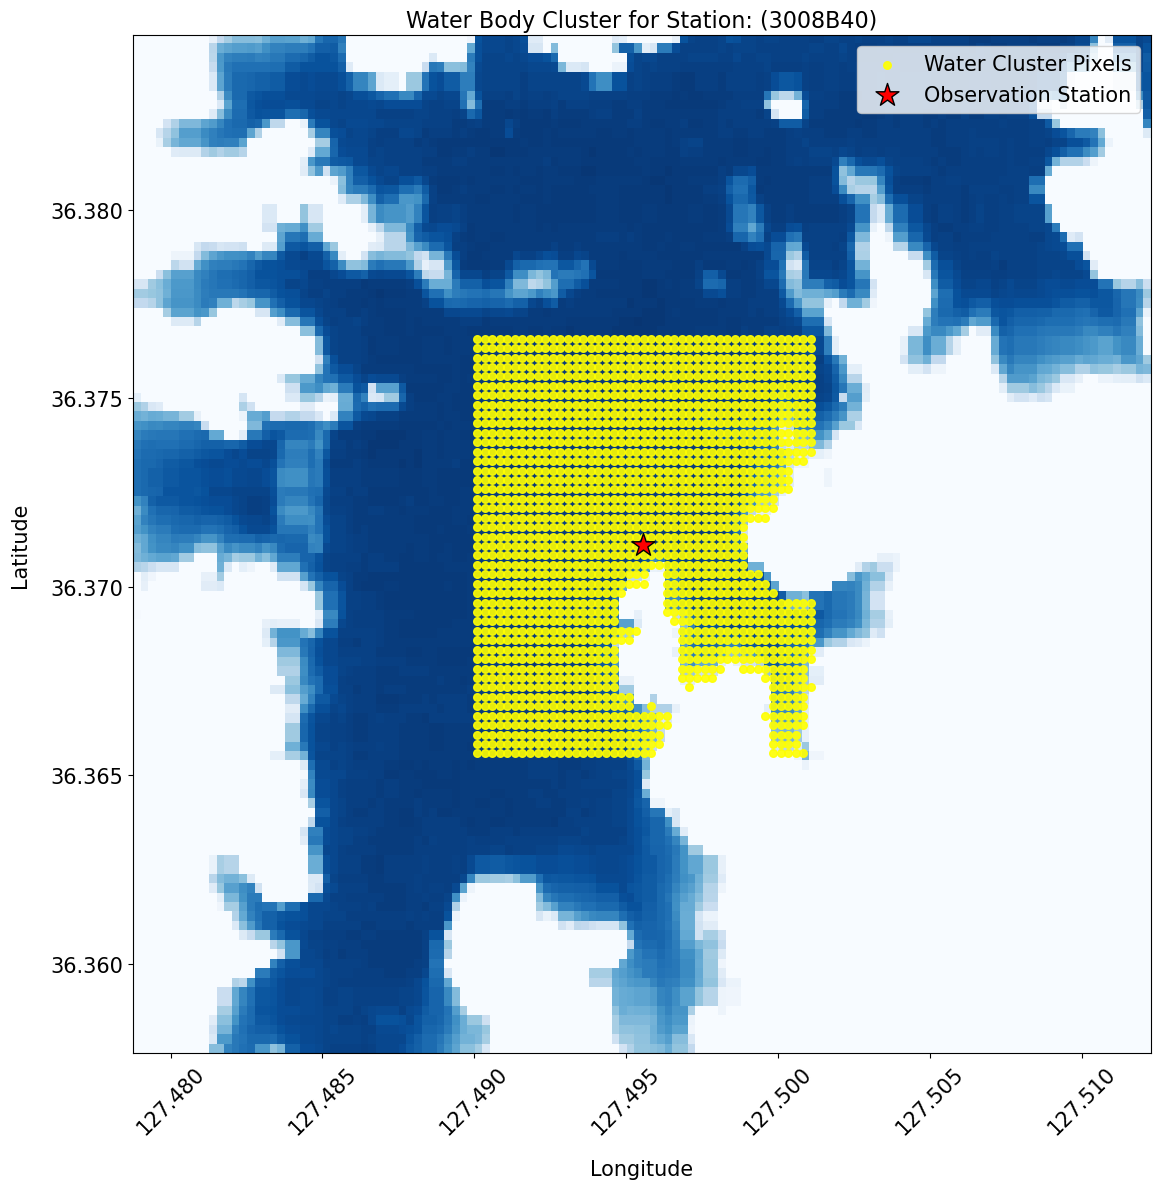

In [10]:
# Assuming 'gdf' is the GeoDataFrame you created earlier

# Specify the station ID you want to plot
target_station = '3008B40'

# Call the plotting function
plot_dbscan(gdf, target_station, pekel_tif_path)